# Learning Project: Document Classification with PyTorch and TorchText

This project builds a text classification model using the AG_NEWS dataset with PyTorch and TorchText. The model predicts the category of a news article (World, Sports, Business, or Sci/Tech) from its raw text. It uses:
- __Tokenization__ and __vocabulary building__ to convert raw text into numeric format
- A __collate function__ with EmbeddingBag for efficient text representation without padding
- A __simple feedforward neural network__ for classification
- __Cross-entropy loss__ and __stochastic gradient descent (SGD)__ for training
- A learning __rate scheduler__ to dynamically adjust training speed

The project demonstrates the full NLP pipeline: from data preprocessing to model training, evaluation, and optimization.

In [1]:
# load libraries 
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import StepLR

In [2]:
# Train test split 
train_iter, test_iter = AG_NEWS(split=('train','test'))

In [ ]:
# Tokenizaiton and Vocab building 
tokenizer = get_tokenizer('basic_english')
# build vocabulary (with generator function to avoid memory inefficiency)
vocab = build_vocab_from_iterator(
    (tokenizer(text) for _,text in train_iter), 
    specials=['<unk>']
)
vocab.set_default_index(vocab['<unk>'])

In [4]:
# Collate function 
## collate function essentially preprocess the batch on the fly 
def collate_batch(batch): 
    # label_list -> store the true class label as int
    # text_list -> store tokenized & indexed text 
    # offset -> starting index of each sample 
    label_list, text_list, offset = [],[],[0]
    for label,text in batch: 
        label_list.append(label - 1) # -1 for 0 indexed 
        processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64) # tokenized & numericalized
        text_list.append(processed_text)
        offset.append(processed_text.size(0)) # basically length of tensor .size is a tensor method to get dim
    # convert label list to label tensor 
    label_tensor = torch.tensor(label_list,dtype=torch.int64)
    # convert text list to text tensor 
    text_tensor = torch.cat(text_list)
    # cumulative offsets: start index of each sample 
    offset_tensor = torch.tensor(offset[:-1]).cumsum(dim=0) # last length no needed; dim = 0 row wised 

    return label_tensor,text_tensor,offset_tensor


In [5]:
# DataLoader 
from torch.utils.data.dataset import random_split
# 95% for training and 5% for validation 
t_len = len(list(AG_NEWS(split='train')))
num_train = int(t_len * 0.95)
num_valid = t_len - num_train
# randomly split training set into training and validation 
train_set, valid_set = random_split(list(AG_NEWS(split='train')), [num_train,num_valid])
# wrap training set into train_dataloader 
train_dataloader = DataLoader(train_set,batch_size=8,shuffle=True,collate_fn=collate_batch)
# wrap validation set into valid_dataloader 
valid_dataloader = DataLoader(valid_set,batch_size=8,collate_fn=collate_batch) # no shuffle, deterministic 
# wrap test set into test_dataloader 
test_dataloader = DataLoader(list(AG_NEWS(split='test')), batch_size=8,collate_fn=collate_batch)

In [6]:
# define the model 
class TextClassificationModel(nn.Module):  # inherits from nn.Module
    def __init__(self,vocab_size, embed_dim, num_class): 
        # super() access parent class (nn.Module) methods 
        super().__init__() # initialize the base(constructor) nn.Module 
        # voccab_size -> # of unique tokens 
        # embed_dim -> dim of word embedding (each word is represented by embed_dim dimension vector)
        self.embedding = nn.EmbeddingBag(vocab_size,embed_dim,sparse = False)
        # fully connected layer 
        ## a simple linear layer that projects the final embedding to class logits.
        self.fc = nn.Linear(embed_dim,num_class)
        # call function init_weights to initiate model weight 
        self.init_weights() 

    # probably not necessary, but I will have one just for good practice 
    def init_weights(self): 
        initrange = 0.5 
        self.embedding.weight.data.uniform_(-initrange,initrange)
        self.fc.weight.data.uniform_(-initrange,initrange)
        self.fc.bias.data.zero_() # initialize biases to zero 

    def forward(self,text,offset): 
        # embedded is a tensor shape of [batch size, embed_dim], which is pooled embedding of a doc 
        embedded = self.embedding(text,offset) # text is 1D tensor 
        return self.fc(embedded)


In [7]:
# initialize model, loss, optimizer, and scheduler 

num_class = 4 # business, sci, sports, world 
vocab_size = len(vocab)
embed_dim = 64 

# init model 
model = TextClassificationModel(vocab_size=vocab_size,embed_dim=embed_dim,num_class=num_class)

# cross entropy loss
criterion = nn.CrossEntropyLoss()
# optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
# scheduler 
## step size -> period of learning rate decay 
## gamma -> multiplicative factor of learning rate decay 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 1,gamma = 0.9) 

In [22]:
# Model Training 
COST = []
ACC = []
def train(dataloder): # dataloader iterate over taining batch 
    # tells the model to operate in training mode 
    model.train()
    # metrics 
    ## total_acc -> total # of correct prediction 
    ## total_loss -> total loss over batches 
    ## total_count -> total # of samples seen 
    total_acc, total_loss, total_count = 0,0,0

    # dataloader contains label, text, offset 
    for labels,text,offsets in dataloder: 
        # clear old gradients 
        optimizer.zero_grad()
        output = model(text,offsets) # nn.Module calls model.__call__() which calls forward() 
        loss = criterion(output,labels) # compute how different the predicted vs. actual probabilities are 
        # backpropagation 
        loss.backward() 
        # gradient clipping (prevents explosion)
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.5)
        # apply gradient update 
        optimizer.step() 

        # accumulate metrics 
        total_loss += loss.item() # float value from loss tensor 
        # argmax(1) find predicted label compare to true label and sum over bool tensor 
        total_acc += (output.argmax(1)==labels).sum().item() 
        total_count += labels.size(0) 

    # return avg loss and accuracy 
    return total_loss/total_count, total_acc/total_count
    
for epoch in range(15): 
    loss,acc = train(train_dataloader) 
    # scheduler step 
    scheduler.step() 
    ACC.append(acc)
    COST.append(loss)
    print(f"Epoch {epoch+1}: Accuracy = {acc}, Loss = {loss}")


Epoch 1: Accuracy = 0.9729122807017544, Loss = 0.012335327060860324
Epoch 2: Accuracy = 0.9739912280701755, Loss = 0.011949708614577989
Epoch 3: Accuracy = 0.975219298245614, Loss = 0.01155469023232992
Epoch 4: Accuracy = 0.9760964912280702, Loss = 0.011269995755281311
Epoch 5: Accuracy = 0.9765175438596492, Loss = 0.010980013410763472
Epoch 6: Accuracy = 0.9776578947368421, Loss = 0.01076044920602693
Epoch 7: Accuracy = 0.9782105263157894, Loss = 0.010485079253242961
Epoch 8: Accuracy = 0.9785350877192982, Loss = 0.010319487481740485
Epoch 9: Accuracy = 0.9792894736842105, Loss = 0.01013931345183176
Epoch 10: Accuracy = 0.9793508771929824, Loss = 0.00999938872396338
Epoch 11: Accuracy = 0.9799035087719298, Loss = 0.009848864161799984
Epoch 12: Accuracy = 0.9803508771929824, Loss = 0.009735138166257472
Epoch 13: Accuracy = 0.9805175438596492, Loss = 0.009615377735072733
Epoch 14: Accuracy = 0.9810087719298246, Loss = 0.009523950389911157
Epoch 15: Accuracy = 0.9809561403508772, Loss = 

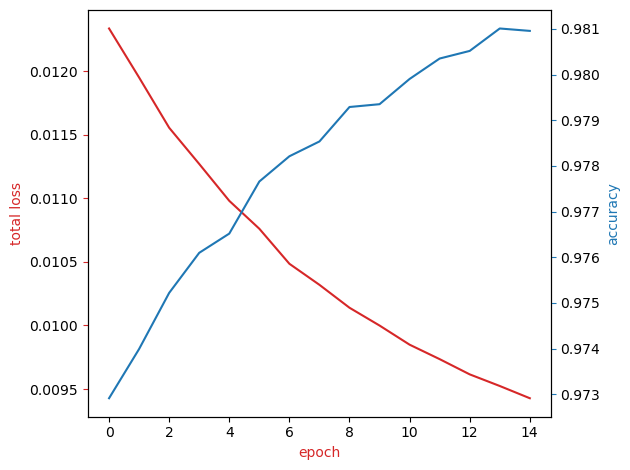

In [23]:
import matplotlib.pyplot as plt
def plot(COST, ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
    plt.show()

plot(COST, ACC)

In [24]:
# evaluation 
def evaluate(dataloader): 
    # put model in evaluation mode 
    model.eval() 
    total_acc, total_count = 0,0 
    # disable gradient computing or storing 
    with torch.no_grad(): 
        for labels,text,offsets in dataloader: 
            output = model(text,offsets)
            total_acc += (output.argmax(1)==labels).sum().item()
            total_count += labels.size(0) 
    return total_acc/total_count # accuracy 

print(f"Validation accuracy: {evaluate(valid_dataloader)}")
print(f"Test accuracy: {evaluate(test_dataloader)}")


Validation accuracy: 0.9101666666666667
Test accuracy: 0.9051315789473684


In [25]:
def predict(text, model, vocab, tokenizer):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        # Tokenize and convert to vocab indices
        tokens = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64)
        # Offsets tensor (starting index for the sentence in the batch)
        offsets = torch.tensor([0])
        # Get the model output
        output = model(tokens, offsets)
        # Get the predicted class index
        predicted_label = output.argmax(1).item()
        return predicted_label

In [26]:
test = 'I think sports like football can be dangerous.' 
label_index = predict(test,model,vocab,tokenizer)
label_map = ["World", "Sports", "Business", "Sci/Tech"]
print(f"Predicted category: {label_map[label_index]}")

Predicted category: Sports
